
# <p style="padding:10px;background-color:#8B0000;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">""Disaster Tweet Detection Using Deep Learning: A Comparative Study of BERT and DistilBERT Models in NLP"</p>

 

### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Problem Statement</p>

#### In this project, we employ machine learning classification models, such as Random Forest and AdaBoost, to predict customer gender, addressing the following challenges:

  - Twitter serves as a crucial platform for real-time emergency communication, largely due to the widespread use of smartphones. 
  - This real-time reporting capability on Twitter has garnered interest from various organizations, such as disaster relief agencies and news outlets, for systematic monitoring.
  - The goal is to develop a machine learning model capable of distinguishing between tweets pertaining to actual disasters and those that are not. 

In [12]:
#pip install text_hammer



In [93]:
#pip install spacy


In [94]:
#pip install transformers



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Importing Libraries</p>

In [14]:
import re
import text_hammer as th
from wordcloud import WordCloud

import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from transformers import AutoTokenizer,TFBertModel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore",  category = FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)




### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Read the Dataset</p>

In [20]:
df = pd.read_csv('train.csv')

In [21]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
#Displaying Shape of the dataset
df.shape

(7613, 5)

In [24]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [25]:
#Dropping the irrelevant colomns
df = df.drop(['keyword','location'], axis=1)

In [26]:
df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1




### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Data Cleaning and Preprocessing</p>

In [27]:
def text_preprocessing(df,col_name):
    tqdm.pandas()
    df[col_name] = df[col_name].progress_apply(lambda x:str(x).lower())
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_urls(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda text: th.cont_exp(text))
    df[col_name] = df[col_name].progress_apply(lambda x: re.sub("[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", "", x))
    df[col_name] = df[col_name].progress_apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))
    df[col_name] = df[col_name].progress_apply(lambda x: ' '.join(x.split()))
    
    return(df)

In [28]:
df = text_preprocessing(df,'text')
df.head()

100%|██████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 363114.92it/s]


,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in ...,1
4,7,just got sent this photo from ruby alaska as s...,1




### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Stopword Removal</p>

In [29]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Explorarity Data Analysis (EDA) </p>



# 
<font color='darkblue' size =5><b>Checking the class distribution of Tweets </b></font> <br> 

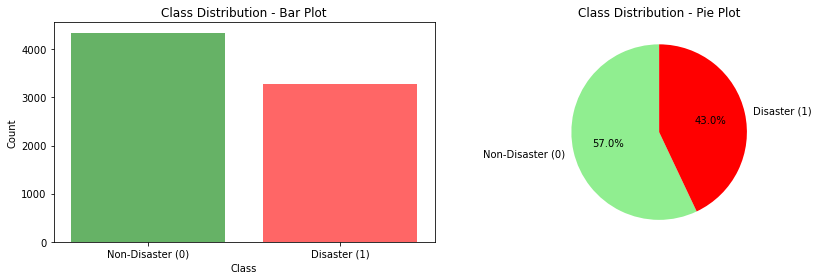

In [95]:
target_counts = df['target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(target_counts.index, target_counts.values, color=['green', 'red'], alpha=0.6)
axes[0].set_xticks(target_counts.index)
axes[0].set_xticklabels(['Non-Disaster (0)', 'Disaster (1)'])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution - Bar Plot')

colors_with_alpha = [(1, 0, 0, 0.6), (0, 0, 1, 0.6)]
axes[1].pie(target_counts, labels=['Non-Disaster (0)', 'Disaster (1)'], colors=['lightgreen', 'red'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution - Pie Plot')

plt.tight_layout()
plt.show()


# 
<font color='darkblue' size =5><b>Checking the character distribution of Tweets </b></font> <br> 

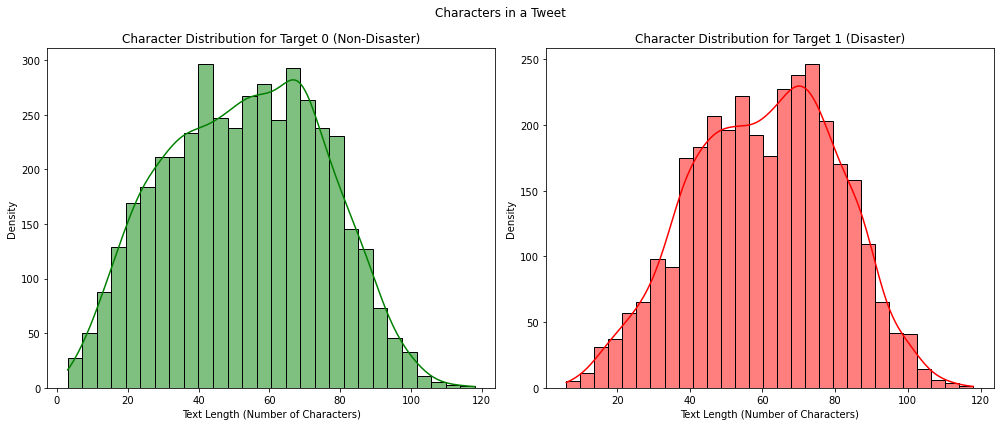

In [45]:
target_0_text = df[df['target'] == 0]['text']
target_1_text = df[df['target'] == 1]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

def create_char_distribution_histogram(text, target_name, ax):
    text = text.str.replace(r'\W', ' ', regex=True)  
    text = text.str.lower()  
    text = text.str.replace(' ', '')  
    text_length = text.str.len()
    
    sns.histplot(text_length, kde=True, color='red' if target_name == '1 (Disaster)' else 'green', ax=ax)
    
    ax.set_xlabel('Text Length (Number of Characters)')
    ax.set_ylabel('Density')
    ax.set_title(f'Character Distribution for Target {target_name}')

create_char_distribution_histogram(target_0_text, '0 (Non-Disaster)', ax1)
create_char_distribution_histogram(target_1_text, '1 (Disaster)', ax2)

plt.suptitle('Characters in a Tweet')
plt.tight_layout()
plt.show()



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Creating Word CLoud</p>

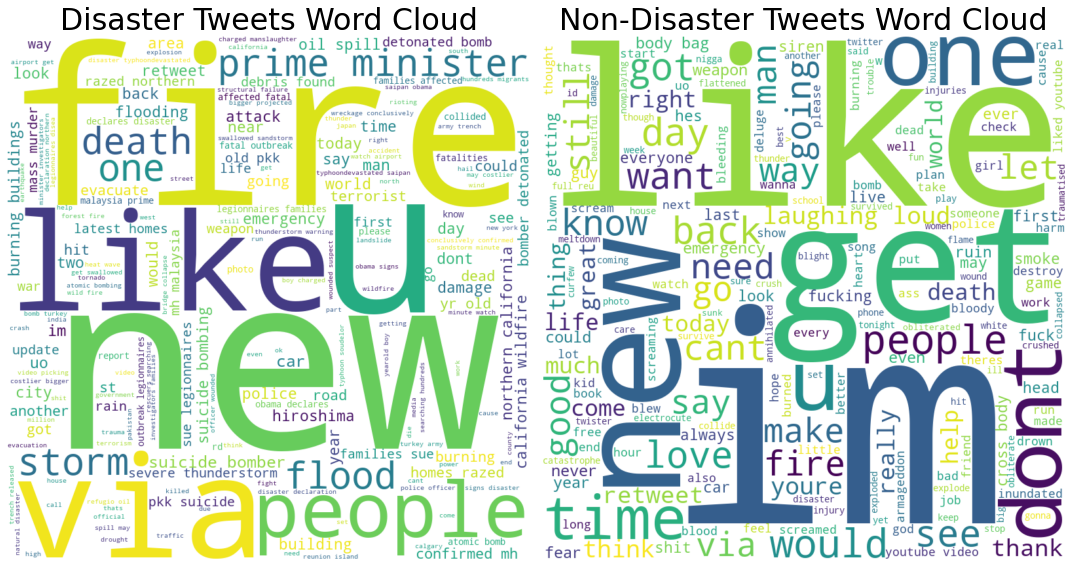

In [62]:
df_disaster = df[df['target'] == 1]
df_non_disaster = df[df['target'] == 0]

# Create a subplot of 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# Word cloud for disaster tweets
wordcloud_disaster = WordCloud(width=800, height=800,
                               background_color='white',
                               stopwords=stopwords.words('english'),
                               min_font_size=10).generate(" ".join(df_disaster['text']))

# Word cloud for non-disaster tweets
wordcloud_non_disaster = WordCloud(width=800, height=800,
                                   background_color='white',
                                   stopwords=stopwords.words('english'),
                                   min_font_size=10).generate(" ".join(df_non_disaster['text']))

# Display the word cloud for disaster tweets
ax1.imshow(wordcloud_disaster, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Disaster Tweets Word Cloud',fontsize=30)

# Display the word cloud for non-disaster tweets
ax2.imshow(wordcloud_non_disaster, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Non-Disaster Tweets Word Cloud', fontsize=30)

# Show the plot
plt.tight_layout()
plt.show()





### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Creating N-Grams</p>


In [64]:
#Defining N-Gram Function
def get_top_ngrams(text, n=100, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngrams = vectorizer.fit_transform(text)
    sum_ngrams = ngrams.sum(axis=0)
    ngram_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    return ngram_freq[:n]


# 
<font color='darkblue' size =5><b>Unigrams </b></font> <br> 

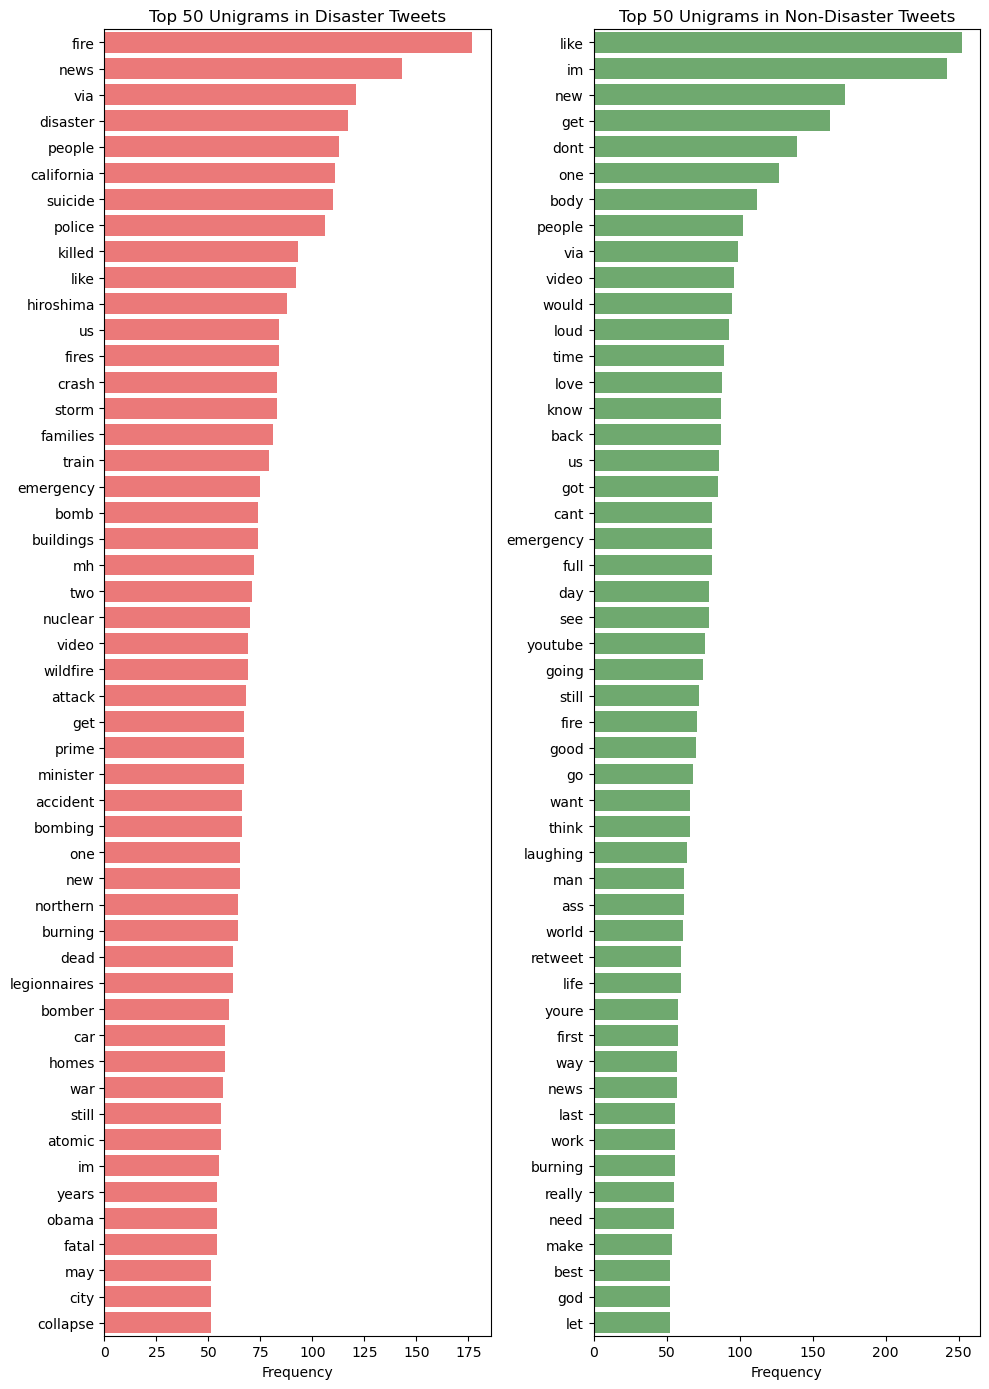

In [70]:
disaster_unigrams = get_top_ngrams(df[df['target'] == 1]['text'], 
                                   n=50, ngram_range=(1, 1))

non_disaster_unigrams = get_top_ngrams(df[df['target'] == 0]['text'], 
                                      n=50, ngram_range=(1, 1))

fig, axes = plt.subplots(dpi=100, figsize=(10, 14), ncols=2)

sns.barplot(y=[word[0] for word in disaster_unigrams], 
            x=[word[1] for word in disaster_unigrams], 
            ax=axes[0], color='red', alpha=0.6)
axes[0].set_title('Top 50 Unigrams in Disaster Tweets')
axes[0].set_xlabel('Frequency')

sns.barplot(y=[word[0] for word in non_disaster_unigrams], 
            x=[word[1] for word in non_disaster_unigrams], 
            ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Top 50 Unigrams in Non-Disaster Tweets')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()


# 
<font color='darkblue' size =5><b>Bigrams</b></font> <br> 

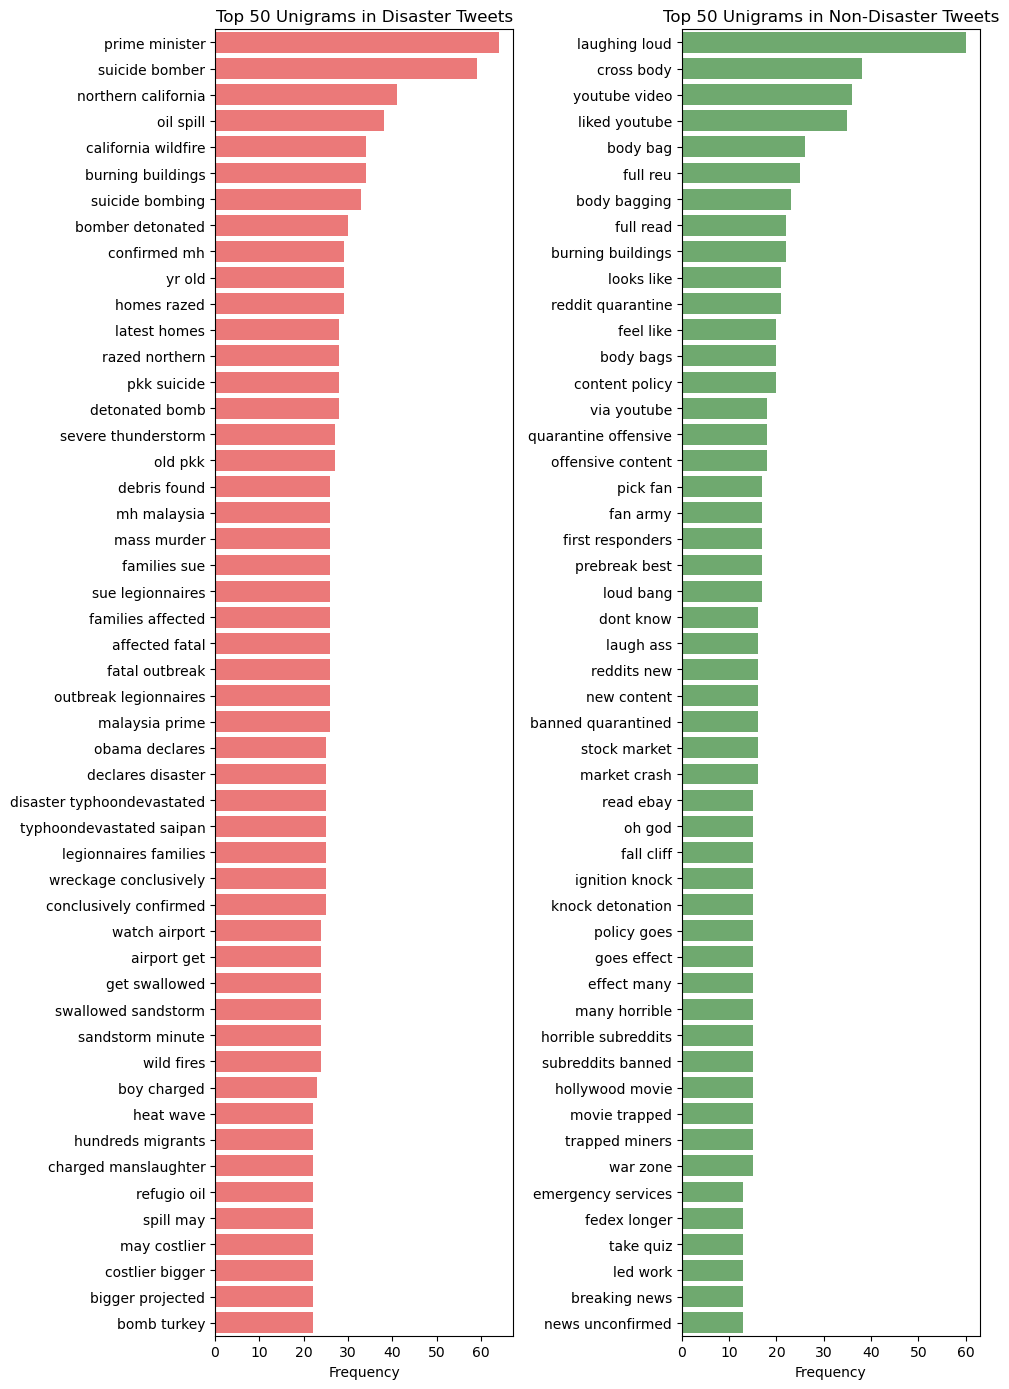

In [71]:
disaster_bigrams = get_top_ngrams(df[df['target'] == 1]['text'], 
                                   n=50, ngram_range=(2, 2))

non_disaster_bigrams = get_top_ngrams(df[df['target'] == 0]['text'], 
                                      n=50, ngram_range=(2, 2))

fig, axes = plt.subplots(dpi=100, figsize=(10, 14), ncols=2)

sns.barplot(y=[word[0] for word in disaster_bigrams], 
            x=[word[1] for word in disaster_bigrams], 
            ax=axes[0], color='red', alpha=0.6)
axes[0].set_title('Top 50 Unigrams in Disaster Tweets')
axes[0].set_xlabel('Frequency')

sns.barplot(y=[word[0] for word in non_disaster_bigrams], 
            x=[word[1] for word in non_disaster_bigrams], 
            ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Top 50 Unigrams in Non-Disaster Tweets')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [76]:
df.head(5)

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1




### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Model Building</p>




# 
<font color='darkblue' size =5><b>Train-Validation Set Split </b></font> <br> 

In [78]:

from sklearn.model_selection import train_test_split

X = df["text"]
y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)





### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">1) BERT : Bidirectional Encoder Representations from Transformers</p>

In [79]:
#BERT Method
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=512)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.values
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val.values
))

# Load the BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(train_dataset.shuffle(100).batch(32), epochs=3, validation_data=val_dataset.batch(32))


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
191/191 [==============================] - 29783s 156s/step - loss: 0.4710 - accuracy: 0.7944 - val_loss: 0.4076 - val_accuracy: 0.8391
Epoch 2/3
191/191 [==============================] - 1849s 10s/step - loss: 0.3479 - accuracy: 0.8604 - val_loss: 0.4484 - val_accuracy: 0.8201
Epoch 3/3
191/191 [==============================] - 2059s 11s/step - loss: 0.2411 - accuracy: 0.9084 - val_loss: 0.5181 - val_accuracy: 0.7892


In [80]:
# Make predictions on the validation set
y_pred_val_raw = model.predict(val_dataset.batch(32))
y_pred_val = tf.argmax(y_pred_val_raw.logits, axis=1).numpy()


48/48 [==============================] - 139s 3s/step




### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">BERT: Model Evaluation</p>

In [81]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)

# Calculate F1 score
f1 = f1_score(y_val, y_pred_val)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


Accuracy: 0.7892317793827971
F1 Score: 0.7584650112866816


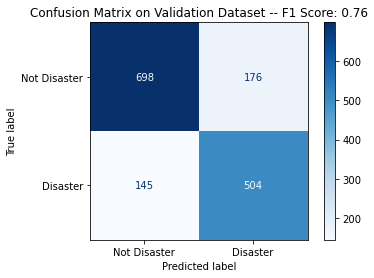

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    disp.ax_.set_title(f"Confusion Matrix on {dataset} Dataset -- F1 Score: {f1_score.round(2)}")

# Display the confusion matrix
displayConfusionMatrix(y_val, y_pred_val, "Validation")






### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">2) DistilBERT</p>

In [85]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=512)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.values
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val.values
))

# Load the DistilBERT model for sequence classification
model_distb = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_distb.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model_distb.fit(train_dataset.shuffle(100).batch(32), epochs=3, validation_data=val_dataset.batch(32))


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
191/191 [==============================] - 1076s 5s/step - loss: 0.4577 - accuracy: 0.7989 - val_loss: 0.4152 - val_accuracy: 0.8240
Epoch 2/3
191/191 [==============================] - 1020s 5s/step - loss: 0.3315 - accuracy: 0.8647 - val_loss: 0.4288 - val_accuracy: 0.8260
Epoch 3/3
191/191 [==============================] - 975s 5s/step - loss: 0.2237 - accuracy: 0.9177 - val_loss: 0.5365 - val_accuracy: 0.7800


In [ ]:
# Make predictions on the train  set
y_pred_train_raw = model_distb.predict(train_dataset.batch(32))
y_pred_train = tf.argmax(y_pred_train_raw.logits, axis=1).numpy()

# Calculate accuracy
accuracy_tr = accuracy_score(y_train, y_pred_train)

# Calculate F1 score
f1_tr = f1_score(y_train, y_pred_train)





### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">DistilBERT : Model Evaluation on Train Set </p>

Accuracy of Validation Set: 0.9474548440065681
F1 Score of Validation Set: 0.9396226415094339


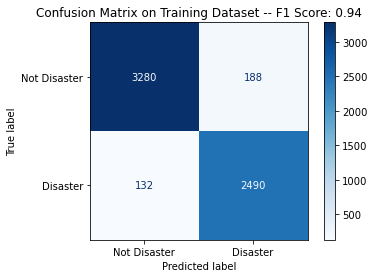

In [92]:
displayConfusionMatrix(y_train, y_pred_train, "Training")

print(f'Accuracy of Validation Set: {accuracy_tr}')
print(f'F1 Score of Validation Set: {f1_tr}')

In [86]:
# Make predictions on the validation set
y_pred_val_raw = model_distb.predict(val_dataset.batch(32))
y_pred_val = tf.argmax(y_pred_val_raw.logits, axis=1).numpy()


48/48 [==============================] - 53s 1s/step


In [90]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)

# Calculate F1 score
f1 = f1_score(y_val, y_pred_val)

print(f'Accuracy of Validation Set: {accuracy}')
print(f'F1 Score of Validation Set: {f1}')


Accuracy of Validation Set: 0.7800393959290873
F1 Score of Validation Set: 0.7608850820842257




### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">DistilBERT : Model Evaluation on Validation Set </p>

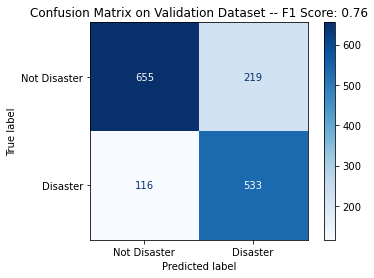

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    disp.ax_.set_title(f"Confusion Matrix on {dataset} Dataset -- F1 Score: {f1_score.round(2)}")

# Display the confusion matrix
displayConfusionMatrix(y_val, y_pred_val, "Validation")



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Test Set Disaster Tweet Detection </p>

In [96]:
test_df = pd.read_csv('test.csv')

In [108]:
test_df_display = pd.read_csv('test.csv')

In [109]:
test_df_display.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [97]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [98]:
test_df.shape

(3263, 4)


# 
<font color='darkblue' size =5><b>Preprocessing and Stopword Removal</b></font> <br> 

In [99]:
#Dropping the irrelevant colomns
test_df = test_df.drop(['keyword','location'], axis=1)
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [100]:
test_df = text_preprocessing(test_df,'text')
test_df.head()

100%|██████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 233717.24it/s]


,id,text
0,0,just happened a terrible car crash
1,2,heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills in china and taiwan


In [101]:
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_df.head()

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different cities stay safe ev...
2,3,forest fire spot pond geese fleeing across str...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills china taiwan


In [103]:
test_df=test_df['text']
test_df.head()

0                          happened terrible car crash
1    heard earthquake different cities stay safe ev...
2    forest fire spot pond geese fleeing across str...
3                apocalypse lighting spokane wildfires
4                  typhoon soudelor kills china taiwan
Name: text, dtype: object



### <p style="padding:10px;background-color:#0f5c59;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">DistilBERT : Test Set Disaster Tweet Detection </p>

#### In this project, we have decided to go with DistilBERT model for classifying the test set tweets as DistilBERT shows better model performnace as compared to BERT


In [104]:
#Tokenize
test_encodings = tokenizer(test_df.tolist(), truncation=True, padding=True, max_length=512)


In [105]:
#Convert to tenserflow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings)
))

In [118]:
# Make predictions on the test set
y_pred_test_raw = model_distb.predict(test_dataset.batch(32))
y_pred_test = tf.argmax(y_pred_test_raw.logits, axis=1).numpy()

102/102 [==============================] - 166s 2s/step


In [119]:
y_pred_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [120]:
total_length = len(test_df)
total_length

3264

In [122]:
test_df_display['Disaster or Not'] = y_pred_test
test_df_display.head(20)

,id,keyword,location,text,Disaster or Not
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
5,12,NaN,NaN,We're shaking...It's an earthquake,1
6,21,NaN,NaN,They'd probably still show more life than Arse...,0
7,22,NaN,NaN,Hey! How are you?,0
8,27,NaN,NaN,What a nice hat?,0
9,29,NaN,NaN,Fuck off!,0




### <p style="padding:10px;background-color:#8B0000;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 20px;overflow:hidden;font-weight:500">Disaster Tweet Detection</p>

In [124]:
#Higlighting disater tweets with red
def highlight_disaster(row):
    if row['Disaster or Not'] == 1:
        return ['background-color: lightcoral'] * len(row)
    else:
        return [''] * len(row)

# Apply the style to the dataframe
styled_df = test_df_display.head(100).style.apply(highlight_disaster, axis=1)
styled_df

,id,keyword,location,text,Disaster or Not
0,0,nan,nan,Just happened a terrible car crash,1
1,2,nan,nan,"Heard about #earthquake is different cities, stay safe everyone.",1
2,3,nan,nan,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,9,nan,nan,Apocalypse lighting. #Spokane #wildfires,1
4,11,nan,nan,Typhoon Soudelor kills 28 in China and Taiwan,1
5,12,nan,nan,We're shaking...It's an earthquake,1
6,21,nan,nan,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",0
7,22,nan,nan,Hey! How are you?,0
8,27,nan,nan,What a nice hat?,0
9,29,nan,nan,Fuck off!,0
